## Загрузка

In [ ]:
!wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
!tar -xzvf ta-lib-0.4.0-src.tar.gz
%cd ta-lib
!./configure --prefix=/usr
!make
!make install
!pip install Ta-Lib
import talib

--2021-01-18 18:42:18--  http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
Resolving prdownloads.sourceforge.net (prdownloads.sourceforge.net)... 216.105.38.13
Connecting to prdownloads.sourceforge.net (prdownloads.sourceforge.net)|216.105.38.13|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz [following]
--2021-01-18 18:42:18--  http://downloads.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz
Resolving downloads.sourceforge.net (downloads.sourceforge.net)... 216.105.38.13
Reusing existing connection to prdownloads.sourceforge.net:80.
HTTP request sent, awaiting response... 302 Found
Location: https://phoenixnap.dl.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz [following]
--2021-01-18 18:42:18--  https://phoenixnap.dl.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz
Resolving phoenixnap

In [ ]:
import importlib.util, sys, gdown

In [ ]:
url = 'https://storage.googleapis.com/aiu_bucket/data.zip'
output = 'data.zip' # Указываем имя файла, в который сохраняем файл
gdown.download(url, output, quiet=True) # Скачиваем файл по указанному URL

'data.zip'

In [ ]:
!unzip -q data.zip -d ''

## Основной блок

In [ ]:
import utils # Подключаем набор функций

In [ ]:
import matplotlib
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from pandas.plotting import lag_plot
from pandas import datetime
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
import talib
%matplotlib inline

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


**Загрузка данных**

In [ ]:
train_dataset, val_dataset = utils.getData() # Загружаем обучающий и проверочный датасет

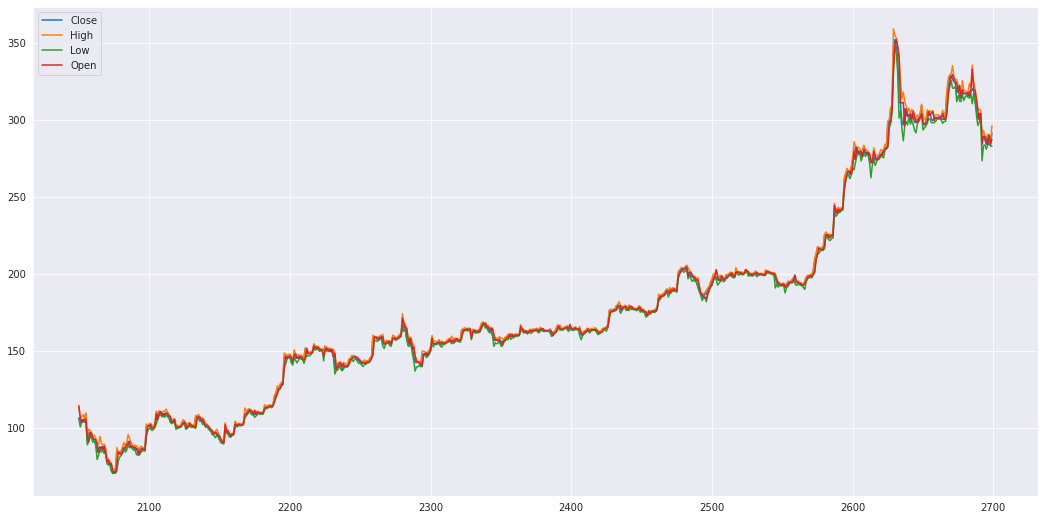

In [ ]:
utils.show_data(train_dataset, start=2050, end=0, param=['Close','High','Low','Open']) # Визуализируем обучающий датасет

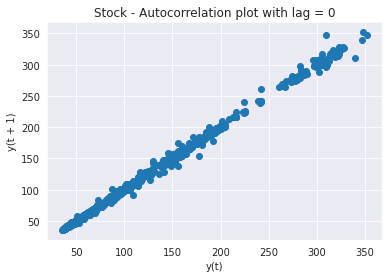

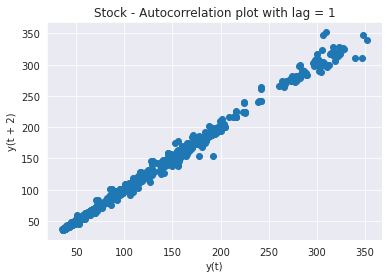

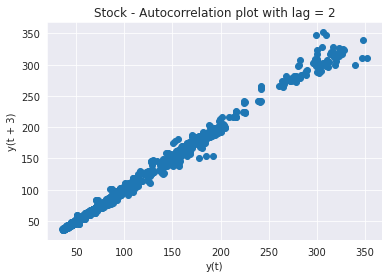

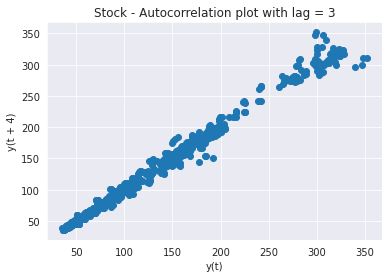

In [ ]:
for i in range(4):
    plt.figure()
    lag_plot(train_dataset['Close'], lag=i+1)
    plt.title(f'Stock - Autocorrelation plot with lag = {i}')
    plt.show()

In [ ]:
# utils.show_data(test_dataset, start=0, end=0, param=['Close','High','Low','Open'])

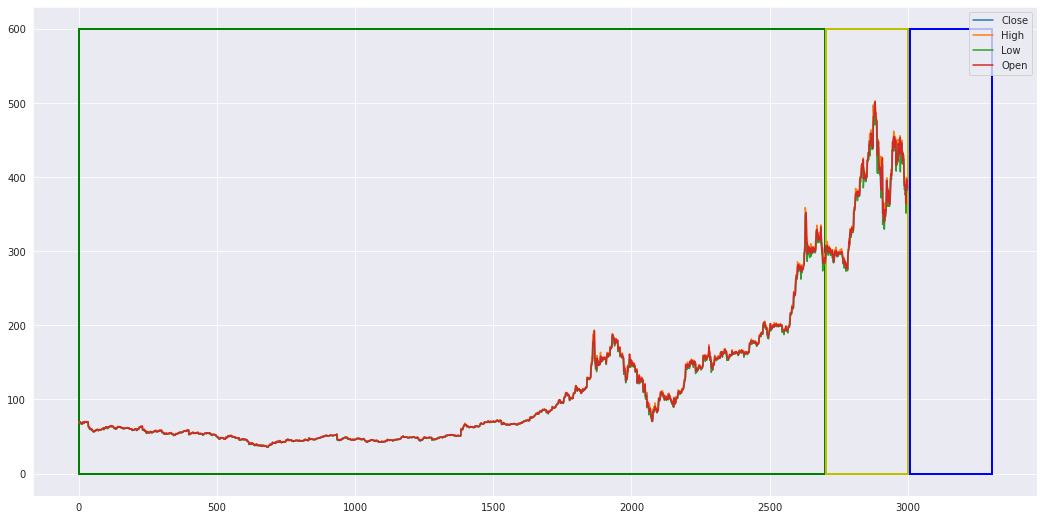

In [ ]:
utils.show_full_data(train_dataset, val_dataset,param=['Close','High','Low','Open'])

**Блок создания нейронной сети**

In [ ]:
def get_precasts(df):
    training_data = df['Close'].values
    history = [x for x in training_data]
    model = ARIMA(history, order=(6,1,0))
    model_fit = model.fit()
    forecast = model_fit.forecast()
    predict = model_fit.predict(typ='levels')
    
    return forecast, predict

**Блок тестирования модели**

In [ ]:
def trade(df, long_price, long_low_price, IS_LONG, maxprice_long, atr):
    low_list = []
    high_list = []
    close_list = []
    close_price = df.iloc[-1]['Close']
    forecast, predict = get_precasts(df)
    forecast, predict = round(forecast[0][0]), round(predict[-1])
    precast = np.average([forecast,predict])

    for i in range(2, 6):
        pos = i * -1
        low_list.append(df.iloc[pos]['Low'])
        high_list.append(df.iloc[pos]['High'])
        close_list.append(round(df.iloc[pos]['Close']))

    if IS_LONG:
        maxprice_long.append(close_price)
        maxprice = maxprice_long[np.argmax(maxprice_long)]
        
        return 2 if (close_price - 2) <= long_price or (
          (maxprice - (long_price*1.052)) >= (maxprice*0.011)) or (
              (precast - round(close_price)) <= -8) else 0
    else:
        if ((np.max(low_list) - np.min(low_list)) <= 8) and atr[-1] >= 7:
            
            return 1 if (close_price - (0.1 * atr[-1])) > np.max(high_list) or (
                (close_price + 1) > close_list[0]) else 0

In [ ]:
# Ваша стратегия
trades_result_list = []
maxprice_long = []
long_price = 0
long_low_price = 0
IS_LONG = False
money = 100000 # Стартовый капитал
shares = 0 # Стартовое количество акций
money_history = [money] # Статистика капитала

# Проходим по всему проверочному набору
for i in range(1, val_dataset.shape[0]+1):
  df = train_dataset.append(val_dataset[:i]).reset_index() # Считываем очередное значение из проверочного набора

  low_list = []
  high_list = []
  close_list = []
  for j in range(1,16):
    low_list.append(df.iloc[-j]['Low'])
    high_list.append(df.iloc[-j]['High'])
    close_list.append(df.iloc[-j]['Close'])
  low_list = np.array(low_list, dtype='float')
  high_list = np.array(high_list, dtype='float')
  close_list = np.array(close_list, dtype='float')
  atr = talib.ATR(high_list,low_list,close_list, timeperiod=7)

  if i == val_dataset.shape[0]:
    action = 2
    IS_LONG = False
  elif (len(df) < 5):
    action = 0
  else:
    action = trade(df, long_price, long_low_price, IS_LONG, maxprice_long, atr) # Получаем действие, которое будем совершать
  
  # Если это последнее значение тестовой выборки

  # Если должны покупать и есть деньги хотя бы на одну акцию
  if action==1 and money > df.iloc[-1]['Close']:
    bal_before = money
    shares += money / df.iloc[-1]['Close'] # Покупаем на все имеющиеся деньги акции (покупаем целое количество (не обязательно))
    money = money % df.iloc[-1]['Close'] # Считаем сколько осталось денег после покупки акций
    long_price = df.iloc[-1]['Close']
    long_low_price = df.iloc[-2]['Low']
    # Выводим статистическую информацию
    print('Купили')
    print('Цена:', df.iloc[-1]['Close'])
    print('Денег:', money)
    print('Акций:', shares)
    print('------------------------')
    IS_LONG = True
    
  # Если должны продавать
  elif action==2:
    money += shares * df.iloc[-1]['Close'] # Продаем все акции и увеличиваем капитал на заработанные деньги

    if bal_before > money: 
        trades_result_list.append(1)
    else: trades_result_list.append(0)
    
    shares = 0 # Количество акцией сбрасываем в 0
    IS_LONG = False
    maxprice_long = []
    # Выводим статистическую информацию
    print('Продали')
    print('Цена:', df.iloc[-1]['Close'])
    print('Денег:', money)
    print('Акций:', shares)
    print('------------------------')  
    money_history.append(money) # Записываем в статистику капитала текущее значение имеющихся денег
    long_price = 0
    long_low_price = 0

  elif action==0 and IS_LONG:
      maxprice_long.append(df.iloc[-1]['Close'])

# Выводим статистику изменения капитала
# plt.figure(figsize=(14,7))
# plt.plot(money_history)
# plt.show()

df = train_dataset.append(val_dataset[:i]).reset_index()

fig = go.Figure(go.Scatter(x = df['index'], y = money_history, connectgaps=True,
                  name='Баланс счета' ))

fig.update_layout(title='Динамика депозита',
                  legend_orientation="h",
                  hovermode='x',
                   plot_bgcolor='rgb(240,240,240)',
                   showlegend=True)

fig.show()

Купили
Цена: 288.23602294921875
Денег: 270.3360595703125
Акций: 346.9378982432669
------------------------
Продали
Цена: 307.79998779296875
Денег: 107057.8169037661
Акций: 0
------------------------
Купили
Цена: 299.302001953125
Денег: 207.00220650047413
Акций: 357.6916165115825
------------------------
Продали
Цена: 301.0205993652344
Денег: 107879.5469967366
Акций: 0
------------------------
Купили
Цена: 303.307861328125
Денег: 205.25622525221843
Акций: 355.6767257015807
------------------------
Продали
Цена: 299.76800537109375
Денег: 106825.75884573671
Акций: 0
------------------------
Купили
Цена: 299.99798583984375
Денег: 26.47588675233419
Акций: 356.0882535483637
------------------------
Продали
Цена: 296.70782470703125
Денег: 105680.64700081313
Акций: 0
------------------------
Купили
Цена: 324.97601318359375
Денег: 63.442716145160375
Акций: 325.19522276590095
------------------------
Продали
Цена: 326.1867980957031
Денег: 106137.8311861733
Акций: 0
------------------------
Купил

In [ ]:
print('Финальный результат: ', round(money,2), 'руб.')

Финальный результат:  195546.46 руб.


In [ ]:
def traide(df):
  '''
  0 - ничего не делать
  1 - покупать
  2 - продавать
  '''
  return np.random.randint(3)

Продали
Цена: 285.96063232421875
Денег: 100000.0
Акций: 0
------------------------
Купили
Цена: 288.23602294921875
Денег: 270.3360595703125
Акций: 346.0
------------------------
Продали
Цена: 294.70599365234375
Денег: 102238.60986328125
Акций: 0
------------------------
Купили
Цена: 299.60736083984375
Денег: 72.49981689453125
Акций: 341.0
------------------------
Продали
Цена: 307.98199462890625
Денег: 105094.35998535156
Акций: 0
------------------------
Купили
Цена: 304.9620056152344
Денег: 187.4300537109375
Акций: 344.0
------------------------
Продали
Цена: 307.3999938964844
Денег: 105933.02795410156
Акций: 0
------------------------
Купили
Цена: 306.53460693359375
Денег: 178.58856201171875
Акций: 345.0
------------------------
Продали
Цена: 304.8340148925781
Денег: 105346.32369995117
Акций: 0
------------------------
Купили
Цена: 300.61199951171875
Денег: 132.12387084960938
Акций: 350.0
------------------------
Продали
Цена: 298.61199951171875
Денег: 104646.32369995117
Акций: 0
---

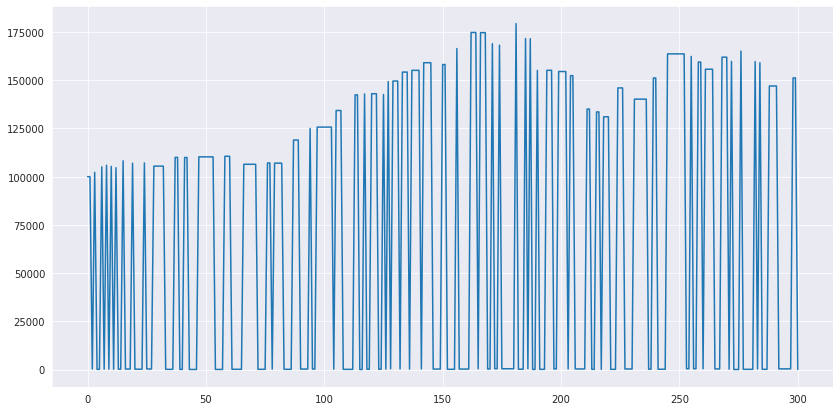

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Ваша стратегия
money = 100000 # Стартовый капитал
shares = 0 # Стартовое количество акций
dataset = train_dataset # В dataset записываем обучающий набор
money_history = [money] # Статистика капитала

# Проходим по всему проверочному набору
for i in range(1, val_dataset.shape[0]+1):
  df = train_dataset.append(val_dataset[:i]).reset_index() # Считываем очередное значение из проверочного набора
  action = traide(df) # Получаем действие, которое будем совершать
  # Если это последнее значение тестовой выборки

  # Если должны покупать и есть деньги хотя бы на одну акцию
  if action==1 and money > df.iloc[-1]['Close']:
    shares += money // df.iloc[-1]['Close'] # Покупаем на все имеющиеся деньги акции (покупаем целое количество (не обязательно))
    money = money % df.iloc[-1]['Close'] # Считаем сколько осталось денег после покупки акций
    
    # Выводим статистическую информацию
    print('Купили')
    print('Цена:', df.iloc[-1]['Close'])
    print('Денег:', money)
    print('Акций:', shares)
    print('------------------------')

  # Если должны продавать
  elif action==2:
    money += shares * df.iloc[-1]['Close'] # Продаем все акции и увеличиваем капитал на заработанные деньги
    shares = 0 # Количество акцией сбрасываем в 0
    
    # Выводим статистическую информацию
    print('Продали')
    print('Цена:', df.iloc[-1]['Close'])
    print('Денег:', money)
    print('Акций:', shares)
    print('------------------------')  
  money_history.append(money) # Записываем в статистику капитала текущее значение имеющихся денег

# Выводим статистику изменения капитала
plt.figure(figsize=(14,7))
plt.plot(money_history)
plt.show()
